In [2]:
# --- Cell 0: configure (minimal changes vs your old notebook) -----------------
import os, sys, math, json, random
from pathlib import Path
import numpy as np
from tqdm import tqdm

# === EDIT THESE THREE TO MATCH YOUR MACHINE ==================================
KITTI_ROOT = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")  # ...\training\
RUN_DIR    = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_from_raw")  # new run
SEED       = 42  # shuffle seed for reproducibility
# ==============================================================================

# Where later cells expect “source” features & labels:
FEAT_SRC_DIR = RUN_DIR / "bev_float"   # (2,H,W) float32: [occ_norm, hag_norm]
GOLD_SRC_DIR = RUN_DIR / "golden"      # (H,W)   uint8  : vehicle core mask

for d in (RUN_DIR, FEAT_SRC_DIR, GOLD_SRC_DIR):
    d.mkdir(parents=True, exist_ok=True)

# ---- BEV grid (keep similar to your previous notebook) -----------------------
# meters per pixel & ranges (KITTI forward=x_lidar, left=y_lidar, up=z_lidar)
RES      = 0.20          # m / pixel
X_MIN, X_MAX = 0.0, 60.0 # forward range [m]
Y_MIN, Y_MAX = -30.0,30.0# left-right range [m]
Z_MIN, Z_MAX = -2.5, 2.5 # vertical slice for height map [m]

# occupancy normalization
OCC_SATURATE = 8.0       # counts mapped to [0..1] by /OCC_SATURATE then clipping

# selection (optional)
MAX_EXPORT   = None      # e.g., 3000 to limit frames; None = all available
KEEP_TYPES   = {"Car","Van","Truck"}  # which KITTI label_2 types count as vehicles

# sanity print
Hx = int((X_MAX - X_MIN) / RES)
Wy = int((Y_MAX - Y_MIN) / RES)
print(f"Output dirs:\n  FEAT_SRC_DIR = {FEAT_SRC_DIR}\n  GOLD_SRC_DIR = {GOLD_SRC_DIR}")
print(f"BEV grid: HxW = {Hx}x{Wy}  |  RES={RES} m/px  |  X=[{X_MIN},{X_MAX}]  Y=[{Y_MIN},{Y_MAX}]  Z=[{Z_MIN},{Z_MAX}]")


Output dirs:
  FEAT_SRC_DIR = D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_from_raw\bev_float
  GOLD_SRC_DIR = D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_from_raw\golden
BEV grid: HxW = 300x300  |  RES=0.2 m/px  |  X=[0.0,60.0]  Y=[-30.0,30.0]  Z=[-2.5,2.5]


In [3]:
# --- Cell 1: export bev_float & golden from raw KITTI -------------------------
# Leaves all later cells unchanged (they will point FEAT_SRC_DIR/GOLD_SRC_DIR here)

# KITTI folders we need
VEL_DIR = KITTI_ROOT / "velodyne"   # *.bin (float32 x,y,z,reflectance)
LAB_DIR = KITTI_ROOT / "label_2"    # *.txt  (3D boxes in cam coords)
CAL_DIR = KITTI_ROOT / "calib"      # *.txt  (R0_rect, Tr_velo_to_cam)

# ----------------------------------------------------------------------------- #
# Helpers
def read_calib(calib_path: Path):
    """
    Returns 4x4 homogeneous transform T_velo_to_rect (rectified camera)
    from KITTI calib file.
    """
    def _row(name, to_shape):
        line = next(l for l in calib_path.read_text().splitlines() if l.startswith(name+":"))
        vals = np.array([float(x) for x in line.split()[1:]], dtype=np.float64)
        return vals.reshape(to_shape)

    Tr = _row("Tr_velo_to_cam", (3,4))
    R0 = _row("R0_rect", (3,3))
    # compose to rect camera
    T = np.eye(4, dtype=np.float64)
    T[:3,:4] = Tr
    T_rect = np.eye(4, dtype=np.float64)
    T_rect[:3,:3] = R0
    return T_rect @ T   # 4x4

def read_labels(label_path: Path):
    """Parse KITTI label_2 vehicles into dicts (in rect camera coords)."""
    items = []
    if not label_path.exists(): return items
    for line in label_path.read_text().splitlines():
        f = line.strip().split()
        if len(f) < 15: 
            continue
        cls = f[0]
        if cls not in KEEP_TYPES: 
            continue
        # dims (h, w, l), location (x, y, z) in cam coords, rotation_y
        h, w, l = map(float, f[8:11])
        x, y, z = map(float, f[11:14])
        ry      = float(f[14])
        items.append(dict(cls=cls, h=h, w=w, l=l, x=x, y=y, z=z, ry=ry))
    return items

def points_in_cam(points_velo_xyz: np.ndarray, T_velo_to_rect: np.ndarray):
    """Transform Nx3 lidar points to rect camera coords (Nx3)."""
    N = points_velo_xyz.shape[0]
    P = np.ones((N,4), dtype=np.float64)
    P[:,:3] = points_velo_xyz
    Q = (T_velo_to_rect @ P.T).T
    return Q[:,:3]  # x,y,z in rect cam

def inside_boxes_mask_cam(P_cam: np.ndarray, boxes):
    """
    For points in rect camera coords (N,3), return boolean mask (N,)
    True if point falls inside ANY vehicle 3D box (KITTI format).
    """
    if len(boxes) == 0 or P_cam.size == 0:
        return np.zeros((P_cam.shape[0],), dtype=bool)
    mask = np.zeros((P_cam.shape[0],), dtype=bool)
    # batch through boxes
    for b in boxes:
        cx, cy, cz = b['x'], b['y'], b['z']
        h, w, l    = b['h'], b['w'], b['l']
        ry         = b['ry']
        # translate
        Q = P_cam - np.array([cx, cy, cz], dtype=np.float64)[None,:]
        # rotate around Y (up in cam coords)
        c, s = math.cos(-ry), math.sin(-ry)
        R = np.array([[ c, 0, s],
                      [ 0, 1, 0],
                      [-s, 0, c]], dtype=np.float64)
        Qr = (R @ Q.T).T
        cond = (
            (np.abs(Qr[:,0]) <= w/2.0) &   # x'
            (np.abs(Qr[:,2]) <= l/2.0) &   # z'
            (Qr[:,1] <=  h/2.0) &          # y' (down is +)
            (Qr[:,1] >= -h/2.0)
        )
        mask |= cond
    return mask

def bev_indices_from_xy(x, y, res=RES):
    """Return integer (ix, iy) for BEV grid with our ranges; -1 means out of bounds."""
    ix = np.floor((x - X_MIN) / res).astype(np.int32)
    iy = np.floor((y - Y_MIN) / res).astype(np.int32)
    Hx = int((X_MAX - X_MIN) / res)
    Wy = int((Y_MAX - Y_MIN) / res)
    good = (ix >= 0) & (ix < Hx) & (iy >= 0) & (iy < Wy)
    return ix, iy, good, Hx, Wy

def build_occ_hag(points_xyz: np.ndarray):
    """
    points_xyz: (N,3) in lidar frame.
    Returns occ_norm (H,W), hag_norm (H,W) in [0,1].
    """
    # filter z & xy to our BEV window
    x, y, z = points_xyz[:,0], points_xyz[:,1], points_xyz[:,2]
    keep = (x >= X_MIN) & (x < X_MAX) & (y >= Y_MIN) & (y < Y_MAX) & (z >= Z_MIN) & (z <= Z_MAX)
    x, y, z = x[keep], y[keep], z[keep]

    # occupancy via 2D histogram on (x,y) with our bins
    Hx = int((X_MAX - X_MIN)/RES)
    Wy = int((Y_MAX - Y_MIN)/RES)
    occ, _, _ = np.histogram2d(x, y, bins=(Hx, Wy),
                               range=((X_MIN, X_MAX), (Y_MIN, Y_MAX)))
    occ = np.clip(occ / OCC_SATURATE, 0.0, 1.0).astype(np.float32)

    # height-against-ground: max z in each cell, normalized to [0,1]
    # create max aggregator
    ix, iy, good, _, _ = bev_indices_from_xy(x, y, RES)
    hag = np.full((Hx, Wy), fill_value=Z_MIN, dtype=np.float32)
    if np.any(good):
        idx = np.ravel_multi_index((ix[good], iy[good]), dims=hag.shape)
        # max-at indices
        np.maximum.at(hag.ravel(), idx, z[good].astype(np.float32))
    hag = (hag - Z_MIN) / max(1e-6, (Z_MAX - Z_MIN))
    hag = np.clip(hag, 0.0, 1.0).astype(np.float32)

    return occ, hag

# ----------------------------------------------------------------------------- #
# Collect frame IDs (present in all 3 folders)
ids_all = sorted([p.stem for p in VEL_DIR.glob("*.bin")
                  if (LAB_DIR/f"{p.stem}.txt").exists() and (CAL_DIR/f"{p.stem}.txt").exists()])

random.seed(SEED)
np.random.seed(SEED)
random.shuffle(ids_all)
if MAX_EXPORT is not None:
    ids_all = ids_all[:int(MAX_EXPORT)]

print(f"Frames to export: {len(ids_all)}")

# ----------------------------------------------------------------------------- #
# Main export loop
pbar = tqdm(ids_all, desc="export bev_float+golden")
saved = 0
for fid in pbar:
    # load velodyne points (Nx4)
    pts = np.fromfile(VEL_DIR/f"{fid}.bin", dtype=np.float32).reshape(-1,4)[:,:3]  # (N,3)
    # build features
    occ, hag = build_occ_hag(pts)

    # labels → golden (vehicle core mask) by checking points inside 3D boxes
    boxes = read_labels(LAB_DIR/f"{fid}.txt")
    if boxes:
        T = read_calib(CAL_DIR/f"{fid}.txt")
        P_cam = points_in_cam(pts, T)              # transform all pts to rect cam
        inside = inside_boxes_mask_cam(P_cam, boxes)
        # Use only points inside any vehicle box, rasterize to BEV grid
        x_in, y_in = pts[inside,0], pts[inside,1]
        ix, iy, good, Hx, Wy = bev_indices_from_xy(x_in, y_in, RES)
        golden = np.zeros((Hx, Wy), dtype=np.uint8)
        if np.any(good):
            golden[ix[good], iy[good]] = 1
    else:
        # no vehicles in this frame
        Hx = int((X_MAX - X_MIN)/RES); Wy = int((Y_MAX - Y_MIN)/RES)
        golden = np.zeros((Hx, Wy), dtype=np.uint8)

    # Save with the exact shapes/types later cells expect
    x2 = np.stack([occ, hag], axis=0).astype(np.float32)   # (2,H,W)
    np.save(FEAT_SRC_DIR/f"{fid}.npy", x2)
    np.save(GOLD_SRC_DIR/f"{fid}.npy", golden.astype(np.uint8))
    saved += 1

print(f"Cell 1 ✓ — exported {saved} frames to:")
print("  ", FEAT_SRC_DIR)
print("  ", GOLD_SRC_DIR)

# quick sanity on one
if saved:
    fid0 = ids_all[0]
    x0 = np.load(FEAT_SRC_DIR/f"{fid0}.npy")
    y0 = np.load(GOLD_SRC_DIR/f"{fid0}.npy")
    print("sample", fid0, "| x2 shape:", x0.shape, "x[min,max]:", float(x0.min()), float(x0.max()),
          "| y shape:", y0.shape, "y sum:", int(y0.sum()))


Frames to export: 7481


export bev_float+golden: 100%|█████████████████████████████████████████████████████| 7481/7481 [09:02<00:00, 13.78it/s]


Cell 1 ✓ — exported 7481 frames to:
   D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_from_raw\bev_float
   D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_from_raw\golden
sample 001736 | x2 shape: (2, 300, 300) x[min,max]: 0.0 1.0 | y shape: (300, 300) y sum: 176


In [4]:
# --- Cell 2: helpers that plug into the v10 outputs ----------------
import warnings
warnings.filterwarnings("ignore")

# Create the downstream folders that later cells expect
FEAT3_DIR = RUN_DIR / "feat3"   # (3,H,W) float32: [occ_norm, hag_norm, edge]
Y_DIR     = RUN_DIR / "y"       # (H,W)   uint8    : halo label (1 inside halo)
W_DIR     = RUN_DIR / "w"       # (H,W)   float32  : per-pixel weights
for d in (FEAT3_DIR, Y_DIR, W_DIR):
    d.mkdir(parents=True, exist_ok=True)

# If these knobs weren't set earlier, define sensible defaults
EDG_Q   = globals().get("EDG_Q",   99.5)   # Sobel magnitude percentile for scaling
HALO_PX = globals().get("HALO_PX",  2)     # halo radius (pixels)
HALO_W  = globals().get("HALO_W",  0.5)    # weight for halo ring (core is 1.0)

# --- dilation (NumPy/SciPy) ---
from scipy.ndimage import binary_dilation

# --- Sobel edges (OpenCV if present; else SciPy) ---
try:
    import cv2
    def sobel_edges(img_f32):
        gx = cv2.Sobel(img_f32, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(img_f32, cv2.CV_32F, 0, 1, ksize=3)
        mag = np.sqrt(gx*gx + gy*gy)
        return mag
except Exception:
    from scipy.ndimage import sobel
    def sobel_edges(img_f32):
        gx = sobel(img_f32, axis=1)
        gy = sobel(img_f32, axis=0)
        mag = np.sqrt(gx*gx + gy*gy)
        return mag

def load_feat2(fid):
    """Read (occ,hag) from FEAT_SRC_DIR created in v10 Cell 1."""
    x = np.load(FEAT_SRC_DIR / f"{fid}.npy")
    if x.ndim == 2:  # extra safety
        x = x[0:1, ...]
    assert x.shape[0] >= 2, f"need [occ,hag] in {fid}"
    occ = x[0].astype(np.float32)
    hag = x[1].astype(np.float32)
    # Normalize conservatively
    occ = np.clip(occ / max(OCC_SATURATE, 1e-6), 0, 1).astype(np.float32)
    if (hag.min() < 0) or (hag.max() > 1.5):
        hag = np.clip((hag + 2.0) / 4.0, 0, 1).astype(np.float32)
    else:
        hag = np.clip(hag, 0, 1).astype(np.float32)
    return occ, hag

def make_edge(occ):
    mag = sobel_edges(occ.astype(np.float32))
    s = np.percentile(mag, EDG_Q)
    s = 1.0 if (not np.isfinite(s)) or (s <= 0) else float(s)
    return np.clip(mag / s, 0, 1).astype(np.float32)

def load_mask(fid):
    g = np.load(GOLD_SRC_DIR / f"{fid}.npy")
    if g.ndim == 3:
        g = g[0]
    return (g > 0).astype(np.uint8)

def make_halo_and_weights(core, r=HALO_PX, halo_w=HALO_W):
    core = (core > 0).astype(np.uint8)
    halo = binary_dilation(core, iterations=int(r)).astype(np.uint8)
    y = halo  # supervise the halo
    w = np.ones_like(y, dtype=np.float32)
    w[(halo == 1) & (core == 0)] = float(halo_w)  # halo ring down-weighted
    return y.astype(np.uint8), w


In [7]:
# --- Cell 3: export feat3/y/w from the v10 sources -----------------
# Collect frame ids present in both v10 outputs

# Grid/tile/training knobs
HALO_PX       = 2          # dilation (pixels) for halo label (≈0.4–0.6 m depending on BEV resolution)
HALO_W        = 0.5        # weight for halo pixels (inner=1.0, halo=0.5)
OCC_SATURATE  = 1.0        # if your OCC is already [0,1], keep 1.0; else set to 8.0 or so
EDG_Q         = 99.5       # robust normalization for edge magnitude
TILE          = 256        # tile size
POS_MIN_PX    = 32         # min #positive pixels to keep a tile as positive
BG_KEEP_FRAC  = 0.20       # randomly keep this fraction of all-zero tiles
SPLIT_SEED    = 42
SPLIT_FRAC    = (0.9, 0.05, 0.05)  # train/val/test by frame

fids = sorted([p.stem for p in FEAT_SRC_DIR.glob("*.npy")
               if (GOLD_SRC_DIR / f"{p.stem}.npy").exists()])
print("frames found:", len(fids))

# Export
for fid in tqdm(fids, desc="export 3ch+halo"):
    occ, hag = load_feat2(fid)
    edge = make_edge(occ)
    x3 = np.stack([occ, hag, edge], axis=0).astype(np.float32)
    ycore = load_mask(fid)
    y, w = make_halo_and_weights(ycore)  # uses HALO_PX/HALO_W defaults above
    np.save(FEAT3_DIR / f"{fid}.npy", x3)
    np.save(Y_DIR     / f"{fid}.npy", y.astype(np.uint8))
    np.save(W_DIR     / f"{fid}.npy", w.astype(np.float32))

# Quick sanity on one
if fids:
    fid0 = fids[0]
    x0 = np.load(FEAT3_DIR / f"{fid0}.npy")
    y0 = np.load(Y_DIR     / f"{fid0}.npy")
    w0 = np.load(W_DIR     / f"{fid0}.npy")
    print("sample", fid0,
          "| X3", x0.shape, float(x0.min()), float(x0.max()),
          "| Y", y0.shape, int(y0.sum()),
          "| W", float(w0.min()), float(w0.max()))
else:
    print("No frames exported. Re-check FEAT_SRC_DIR/GOLD_SRC_DIR.")


frames found: 7481


export 3ch+halo: 100%|█████████████████████████████████████████████████████████████| 7481/7481 [02:41<00:00, 46.33it/s]

sample 000000 | X3 (3, 300, 300) 0.0 1.0 | Y (300, 300) 0 | W 1.0 1.0


In [8]:
#Cell 4

DS_DIR = RUN_DIR/"dataset_3ch_halo"
for d in [DS_DIR/"train", DS_DIR/"val", DS_DIR/"test"]:
    d.mkdir(parents=True, exist_ok=True)

random.seed(SPLIT_SEED)
fids_shuf = fids.copy()
random.shuffle(fids_shuf)
n = len(fids_shuf)
n_train = int(n*SPLIT_FRAC[0]); n_val = int(n*SPLIT_FRAC[1])
splits = {
    "train": fids_shuf[:n_train],
    "val":   fids_shuf[n_train:n_train+n_val],
    "test":  fids_shuf[n_train+n_val:],
}
print({k:len(v) for k,v in splits.items()})

def write_tile_set(split, keep_bg_frac=BG_KEEP_FRAC):
    outdir = DS_DIR/split
    kept = 0
    for fid in tqdm(splits[split], desc=f"tiles {split}"):
        X = np.load(FEAT3_DIR/f"{fid}.npy").astype(np.float32)     # (3,H,W)
        Y = np.load(Y_DIR/f"{fid}.npy").astype(np.uint8)           # (H,W)
        Wt= np.load(W_DIR/f"{fid}.npy").astype(np.float32)         # (H,W)
        H,W = Y.shape
        for y0 in range(0, H, TILE):
            for x0 in range(0, W, TILE):
                if y0+TILE>H or x0+TILE>W: 
                    continue
                ytile = Y[y0:y0+TILE, x0:x0+TILE]
                if ytile.sum() >= POS_MIN_PX:
                    xtile = X[:, y0:y0+TILE, x0:x0+TILE]
                    wtile = Wt[y0:y0+TILE, x0:x0+TILE]
                    name = f"{fid}_{y0:04d}_{x0:04d}"
                    np.save(outdir/f"{name}_x.npy", xtile)
                    np.save(outdir/f"{name}_y.npy", ytile)
                    np.save(outdir/f"{name}_w.npy", wtile)
                    kept += 1
                else:
                    if random.random() < keep_bg_frac:
                        xtile = X[:, y0:y0+TILE, x0:x0+TILE]
                        wtile = Wt[y0:y0+TILE, x0:x0+TILE]
                        name = f"{fid}_{y0:04d}_{x0:04d}"
                        np.save(outdir/f"{name}_x.npy", xtile)
                        np.save(outdir/f"{name}_y.npy", ytile)
                        np.save(outdir/f"{name}_w.npy", wtile)
                        kept += 1
    return kept

stats = {}
for sp in ["train","val","test"]:
    stats[sp] = write_tile_set(sp)
print("tile counts:", stats)


{'train': 6732, 'val': 374, 'test': 375}


tiles test: 100%|████████████████████████████████████████████████████████████████████| 375/375 [00:31<00:00, 11.81it/s]

tile counts: {'train': 5877, 'val': 315, 'test': 333}


In [9]:
# Cell 5 — probe dataset folders (train/val/test)
from pathlib import Path
import numpy as np
DS_DIR = RUN_DIR/"dataset_3ch_halo"
def probe(root: Path):
    root = Path(root)
    xs = sorted(root.glob("*_x.npy"))
    ys = [root / (p.stem[:-2] + "_y.npy") for p in xs]
    ws = [root / (p.stem[:-2] + "_w.npy") for p in xs]

    pos, tot = 0, 0
    for yp in ys[:min(1000, len(ys))]:   # sample up to 1000 masks
        y = np.load(yp).astype(np.uint8)
        pos += int(y.sum()); tot += y.size

    approx = 100.0 * pos / max(tot, 1)
    print(f"{root.name:>6} | tiles={len(xs):5d} | approx pos%={approx:6.3f}")

    if xs:
        x = np.load(xs[0]).astype(np.float32)  # (C,H,W)
        y = np.load(ys[0]).astype(np.uint8)    # (H,W)
        w = np.load(ws[0]).astype(np.float32)  # (H,W)
        print("shapes:", x.shape, y.shape, w.shape,
              " | x[min,max]:", float(x.min()), float(x.max()))

# Adjust DS_DIR to your dataset root if needed
probe(DS_DIR / "train")
probe(DS_DIR / "val")
probe(DS_DIR / "test")


 train | tiles= 5877 | approx pos%= 0.616
shapes: (3, 256, 256) (256, 256) (256, 256)  | x[min,max]: 0.0 1.0
   val | tiles=  315 | approx pos%= 0.668
shapes: (3, 256, 256) (256, 256) (256, 256)  | x[min,max]: 0.0 1.0
  test | tiles=  333 | approx pos%= 0.554
shapes: (3, 256, 256) (256, 256) (256, 256)  | x[min,max]: 0.0 1.0


In [10]:
#Cell 6

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IN_CH  = 3
BASE   = 16

class TinyUNet(nn.Module):
    def __init__(self, in_ch=IN_CH, base=BASE):
        super().__init__()
        self.e1 = nn.Sequential(nn.Conv2d(in_ch, base, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base, base, 3, padding=1), nn.ReLU())
        self.p1 = nn.MaxPool2d(2)
        self.e2 = nn.Sequential(nn.Conv2d(base, base*2, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base*2, base*2, 3, padding=1), nn.ReLU())
        self.p2 = nn.MaxPool2d(2)
        self.b  = nn.Sequential(nn.Conv2d(base*2, base*4, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base*4, base*4, 3, padding=1), nn.ReLU())
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.d2 = nn.Sequential(nn.Conv2d(base*4, base*2, 3, padding=1), nn.ReLU())
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.d1 = nn.Sequential(nn.Conv2d(base*2, base, 3, padding=1), nn.ReLU())
        self.out= nn.Conv2d(base, 1, 1)
    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p1(e1))
        b  = self.b(self.p2(e2))
        d2 = self.u2(b); d2 = self.d2(torch.cat([d2, e2], dim=1))
        d1 = self.u1(d2); d1 = self.d1(torch.cat([d1, e1], dim=1))
        return self.out(d1)  # (B,1,H,W)


In [11]:
#Cell 7

BATCH  = 16
EPOCHS = 20
LR     = 1e-3
POS_W  = 20.0         # scales all positive pixels (helps big imbalance)
EVAL_DIL_R = 2        # pixels for dilated-IoU reporting

class NpyTiles(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.xs = sorted(self.root.glob("*_x.npy"))
        self.ys = [self.root/(p.stem[:-2]+"_y.npy") for p in self.xs]
        self.ws = [self.root/(p.stem[:-2]+"_w.npy") for p in self.xs]
        assert len(self.xs)==len(self.ys)==len(self.ws)>0
    def __len__(self): return len(self.xs)
    def __getitem__(self, i):
        x = np.load(self.xs[i]).astype(np.float32)           # (C,H,W)
        y = np.load(self.ys[i]).astype(np.uint8)[None,...]   # (1,H,W)
        w = np.load(self.ws[i]).astype(np.float32)[None,...] # (1,H,W)
        return torch.from_numpy(x), torch.from_numpy(y.astype(np.float32)), torch.from_numpy(w)

train_ds = NpyTiles(DS_DIR/"train")
val_ds   = NpyTiles(DS_DIR/"val")

# simple sampler: weight by fraction of positives in tile
def tile_pos_frac(ypath):
    y = np.load(ypath).astype(np.uint8); return y.mean()
weights=[]
for yp in [train_ds.ys[i] for i in range(len(train_ds))]:
    f = tile_pos_frac(yp); weights.append(0.5/max(f,1e-4) if f>0 else 0.5/max(1-f,1e-4))
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0)

m = TinyUNet(IN_CH).to(device)
opt = torch.optim.Adam(m.parameters(), lr=LR)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=4)
posw = torch.tensor([POS_W], device=device)

def loss_weighted(logits, y, w):
    # BCE per-pixel, then multiply by per-pixel weight map
    l = F.binary_cross_entropy_with_logits(logits, y, pos_weight=posw, reduction='none')
    return (l * w).mean()

def eval_iou(loader, thr=0.5, dilate_r=0):
    m.eval(); inter=0; union=0
    with torch.no_grad():
        for xb,yb,wb in loader:
            xb,yb = xb.to(device), yb.to(device)
            p = (torch.sigmoid(m(xb)) > thr).float()
            if dilate_r>0:
                yb = F.max_pool2d(yb, kernel_size=2*dilate_r+1, stride=1, padding=dilate_r)
            inter += (p*yb).sum().item()
            union += (p + yb - p*yb).sum().item()
    return 0.0 if union==0 else inter/union

best, best_path = 0.0, RUN_DIR/"tiny_bev_halo.pt"
print(f"tiles: train={len(train_ds)} val={len(val_ds)} in_ch={IN_CH}")

for ep in range(1, EPOCHS+1):
    m.train(); tot=0; n=0
    for xb,yb,wb in train_loader:
        xb,yb,wb = xb.to(device), yb.to(device), wb.to(device)
        logits = m(xb)
        loss = loss_weighted(logits, yb, wb)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*xb.size(0); n += xb.size(0)
    i30 = eval_iou(val_loader, 0.30, dilate_r=EVAL_DIL_R)
    i40 = eval_iou(val_loader, 0.40, dilate_r=EVAL_DIL_R)
    i50 = eval_iou(val_loader, 0.50, dilate_r=EVAL_DIL_R)
    sch.step(1.0 - i50)
    print(f"epoch {ep:02d} | train_loss {tot/n:.4f} | val IoU(d{EVAL_DIL_R}) t0.30:{i30:.3f} t0.40:{i40:.3f} t0.50:{i50:.3f}")
    if i50 > best:
        best = i50
        torch.save(m.state_dict(), best_path)

print("saved model to:", best_path)


tiles: train=5877 val=315 in_ch=3
epoch 01 | train_loss 0.1535 | val IoU(d2) t0.30:0.156 t0.40:0.147 t0.50:0.120
epoch 02 | train_loss 0.0860 | val IoU(d2) t0.30:0.258 t0.40:0.262 t0.50:0.258
epoch 03 | train_loss 0.0643 | val IoU(d2) t0.30:0.337 t0.40:0.343 t0.50:0.339
epoch 04 | train_loss 0.0516 | val IoU(d2) t0.30:0.364 t0.40:0.378 t0.50:0.382
epoch 05 | train_loss 0.0468 | val IoU(d2) t0.30:0.366 t0.40:0.385 t0.50:0.395
epoch 06 | train_loss 0.0417 | val IoU(d2) t0.30:0.364 t0.40:0.382 t0.50:0.389
epoch 07 | train_loss 0.0377 | val IoU(d2) t0.30:0.416 t0.40:0.412 t0.50:0.400
epoch 08 | train_loss 0.0358 | val IoU(d2) t0.30:0.393 t0.40:0.410 t0.50:0.418
epoch 09 | train_loss 0.0339 | val IoU(d2) t0.30:0.431 t0.40:0.437 t0.50:0.431
epoch 10 | train_loss 0.0311 | val IoU(d2) t0.30:0.441 t0.40:0.431 t0.50:0.414
epoch 11 | train_loss 0.0317 | val IoU(d2) t0.30:0.424 t0.40:0.442 t0.50:0.452
epoch 12 | train_loss 0.0294 | val IoU(d2) t0.30:0.433 t0.40:0.446 t0.50:0.451
epoch 13 | train_l

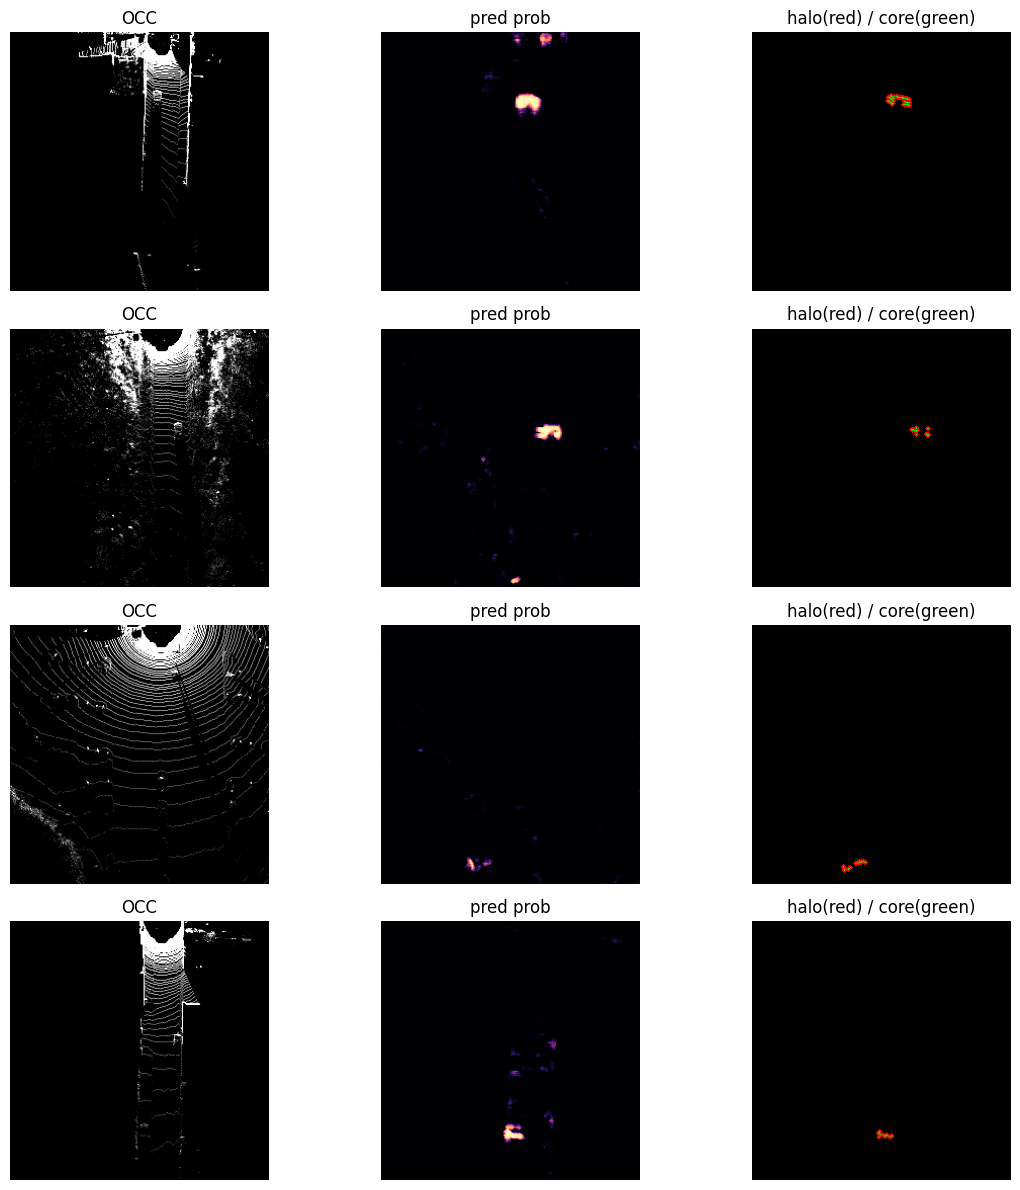

In [12]:
#Cell 8

import matplotlib.pyplot as plt

# pick a few random val tiles
batch = next(iter(val_loader))
xb,yb,wb = [t.to(device) for t in batch]
m.eval()
with torch.no_grad():
    pr = torch.sigmoid(m(xb)).cpu().numpy()

k = min(4, xb.size(0))
plt.figure(figsize=(12, k*3))
for i in range(k):
    occ = xb[i,0].cpu().numpy()
    prb = pr[i,0]
    yy  = yb[i,0].cpu().numpy()
    ww  = wb[i,0].cpu().numpy()
    core = (ww>0.99) & (yy>0)   # inner
    halo = (ww<0.99) & (yy>0)   # halo ring
    plt.subplot(k,3,3*i+1); plt.imshow(occ, cmap='gray'); plt.title("OCC"); plt.axis('off')
    plt.subplot(k,3,3*i+2); plt.imshow(prb, cmap='magma'); plt.title("pred prob"); plt.axis('off')
    mask_vis = np.zeros((*yy.shape,3), np.float32)
    mask_vis[...,0] = halo*1.0  # red=halo
    mask_vis[...,1] = core*1.0  # green=core
    plt.subplot(k,3,3*i+3); plt.imshow(mask_vis); plt.title("halo(red) / core(green)"); plt.axis('off')
plt.tight_layout(); plt.show()


In [15]:
# Cell 9: Evaluation (fixed): PR/ROC + IoU at a few thresholds --------------------
import numpy as np
import torch, torch.nn.functional as F

# try to use sklearn; fall back to a simple numpy implementation if unavailable
try:
    from sklearn.metrics import precision_recall_curve, roc_curve, auc
    _HAS_SK = True
except Exception:
    _HAS_SK = False
    def _pr_curve(y, p):
        ts = np.linspace(0.0, 1.0, 101)
        prec, rec = [], []
        for t in ts:
            pred = (p >= t).astype(np.uint8)
            tp = (pred & y).sum()
            fp = (pred & (1-y)).sum()
            fn = ((1-pred) & y).sum()
            pr = tp / max(tp+fp, 1e-9)
            rc = tp / max(tp+fn, 1e-9)
            prec.append(pr); rec.append(rc)
        return np.array(prec), np.array(rec), ts
    def _roc_curve(y, p):
        ts = np.linspace(0.0, 1.0, 101)
        fpr, tpr = [], []
        n_pos = y.sum(); n_neg = len(y) - n_pos
        for t in ts:
            pred = (p >= t).astype(np.uint8)
            tp = (pred & y).sum()
            fp = (pred & (1-y)).sum()
            tpr.append(tp / max(n_pos, 1e-9))
            fpr.append(fp / max(n_neg, 1e-9))
        return np.array(fpr), np.array(tpr), ts
    def _auc(x, y):
        # trapezoid rule (x must be monotonic)
        idx = np.argsort(x)
        return np.trapz(y[idx], x[idx])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# path & model must match what you used during training
BEST_PT = RUN_DIR / "tiny_bev_halo.pt"

# TinyUNet, IN_CH, EVAL_DIL_R, val_loader must already exist from earlier cells
model = TinyUNet(IN_CH).to(device)
model.load_state_dict(torch.load(BEST_PT, map_location=device))
model.eval()

# collect probabilities and labels on the VAL set
probs, labels = [], []
with torch.no_grad():
    for xb, yb, wb in val_loader:
        xb = xb.to(device)
        p  = torch.sigmoid(model(xb)).detach().cpu().numpy().ravel()
        y  = yb.numpy().astype(np.uint8).ravel()
        probs.append(p); labels.append(y)
probs  = np.concatenate(probs)
labels = np.concatenate(labels)

# curves + AUC
if _HAS_SK:
    prec, rec, thr_pr = precision_recall_curve(labels, probs)
    fpr,  tpr, thr_ro = roc_curve(labels, probs)
    auc_pr  = auc(rec, prec)
    auc_roc = auc(fpr, tpr)
else:
    prec, rec, thr_pr = _pr_curve(labels, probs)
    fpr,  tpr, thr_ro = _roc_curve(labels, probs)
    auc_pr  = _auc(rec, prec)
    auc_roc = _auc(fpr, tpr)

# best-F1 threshold (note: sklearn returns |thr| = |prec|-1)
f1 = 2*prec*rec/(prec+rec+1e-9)
i_best = int(np.nanargmax(f1))
t_best = (thr_pr[i_best] if _HAS_SK and i_best < len(thr_pr)
          else float(np.linspace(0.0,1.0,101)[i_best]))

TARGET_PREC = 0.80
idx = np.where(prec[:-1] >= TARGET_PREC)[0] if _HAS_SK else np.where(prec >= TARGET_PREC)[0]
t_prec = (thr_pr[idx[0]] if _HAS_SK else float(np.linspace(0.0,1.0,101)[idx[0]])) if len(idx) else None

def metrics_at_threshold(t: float):
    """IoU(dilated), Precision, Recall, F1 on VAL set at threshold t."""
    inter=union=tp=fp=fn=0.0
    with torch.no_grad():
        for xb, yb, wb in val_loader:
            xb = xb.to(device)
            yb_t = yb.to(device).float()
            pred = (torch.sigmoid(model(xb)) > t).float()

            # IoU with dilation on the GT (matches training printout)
            if EVAL_DIL_R > 0:
                y_iou = F.max_pool2d(yb_t, kernel_size=2*EVAL_DIL_R+1, stride=1, padding=EVAL_DIL_R)
            else:
                y_iou = yb_t
            inter += (pred * y_iou).sum().item()
            union += (pred + y_iou - pred*y_iou).sum().item()

            # vanilla PR (no dilation)
            tp += (pred * yb_t).sum().item()
            fp += (pred * (1 - yb_t)).sum().item()
            fn += ((1 - pred) * yb_t).sum().item()

    iou = inter/union if union > 0 else 0.0
    precision = tp / max(tp + fp, 1e-9)
    recall    = tp / max(tp + fn, 1e-9)
    f1        = 2*precision*recall / max(precision + recall, 1e-9)
    return dict(th=t, iou=iou, precision=precision, recall=recall, f1=f1)

m_best = metrics_at_threshold(t_best)
m30    = metrics_at_threshold(0.30)
m40    = metrics_at_threshold(0.40)
m50    = metrics_at_threshold(0.50)

print(f"[Val] PR-AUC={auc_pr:.3f} | ROC-AUC={auc_roc:.3f}")
print(f"[Val] Best-F1 thr={m_best['th']:.3f} -> IoU(d{EVAL_DIL_R})={m_best['iou']:.3f}  "
      f"P={m_best['precision']:.2f}  R={m_best['recall']:.2f}  F1={m_best['f1']:.3f}")
if t_prec is not None:
    mp = metrics_at_threshold(t_prec)
    print(f"[Val] Thr for ≥80% precision t={t_prec:.3f} -> IoU(d{EVAL_DIL_R})={mp['iou']:.3f}  "
          f"P={mp['precision']:.2f}  R={mp['recall']:.2f}  F1={mp['f1']:.3f}")
else:
    print("[Val] Could not reach 80% precision on this set.")
print(f"[Val] IoU(d{EVAL_DIL_R}) @ 0.30={m30['iou']:.3f}  0.40={m40['iou']:.3f}  0.50={m50['iou']:.3f}")


[Val] PR-AUC=0.749 | ROC-AUC=0.994
[Val] Best-F1 thr=0.883 -> IoU(d2)=0.354  P=0.70  R=0.68  F1=0.687
[Val] Thr for ≥80% precision t=0.948 -> IoU(d2)=0.272  P=0.80  R=0.55  F1=0.654
[Val] IoU(d2) @ 0.30=0.463  0.40=0.472  0.50=0.471
